Data
Release: Advance Monthly Sales for Retail and Food Services
Units: Millions of Dollars, Not Seasonally Adjusted

Frequency: Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation: U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [23]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv('../Data/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [25]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [26]:
df.columns = ['Sales']

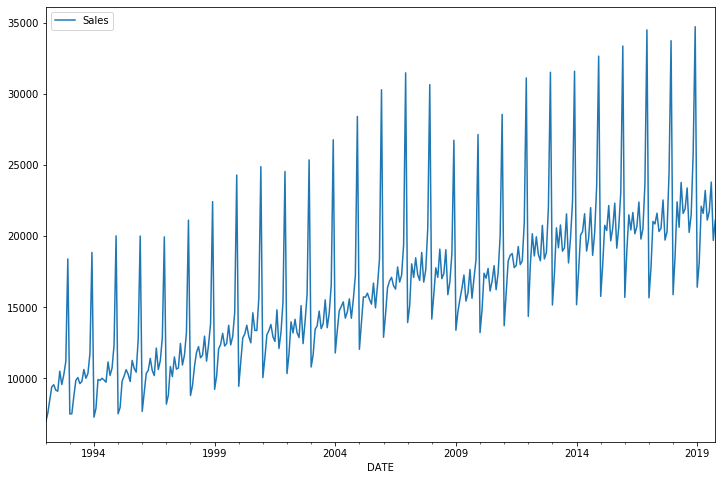

In [27]:
df.plot(figsize=(12,8))

In [28]:
len(df)

334

In [29]:
len(df) - 18

316

In [30]:
test_size = 18
test_ind = len(df)-test_size

In [31]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [32]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [33]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [34]:
from sklearn.preprocessing import MinMaxScaler

In [35]:
scaler = MinMaxScaler()

In [36]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [37]:
scaled_train = scaler.transform(train)

In [38]:
scaled_test = scaler.transform(test)

In [39]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [40]:
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)

In [41]:
X,y = generator[0]

In [42]:
# X

In [43]:
# len(X[0])

In [44]:
# y

In [45]:
# scaled_train

In [46]:
from tensorflow.keras.models import Sequential

In [47]:
from tensorflow.keras.layers import Dense,LSTM

In [48]:
n_features = 1

In [49]:
model = Sequential()
model.add(LSTM(100,activation='relu', input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [51]:
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [53]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,batch_size=1)

In [54]:
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 6s 21ms/step - loss: 0.0244 - val_loss: 0.0288
Epoch 2/20
304/304 [==============================] - 7s 21ms/step - loss: 0.0169 - val_loss: 0.0025
Epoch 3/20
304/304 [==============================] - 6s 21ms/step - loss: 0.0075 - val_loss: 0.0109
Epoch 4/20
304/304 [==============================] - 6s 21ms/step - loss: 0.0038 - val_loss: 0.0027


In [55]:
losses = pd.DataFrame(model.history.history)

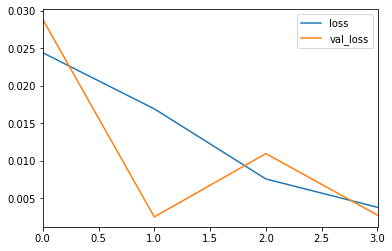

In [56]:
losses.plot()

In [57]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [58]:
true_predictions = scaler.inverse_transform(test_predictions)

In [59]:
test['Predictions'] = true_predictions

c:\users\esaeri-1122\appdata\local\continuum\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22320.790208
2018-06-01,21589,21340.834358
2018-07-01,21919,21611.606599
2018-08-01,23381,23321.783447
2018-09-01,20260,21073.480241
2018-10-01,21473,21766.407238
2018-11-01,25831,25441.787148
2018-12-01,34706,35526.957671
2019-01-01,16410,17472.752361


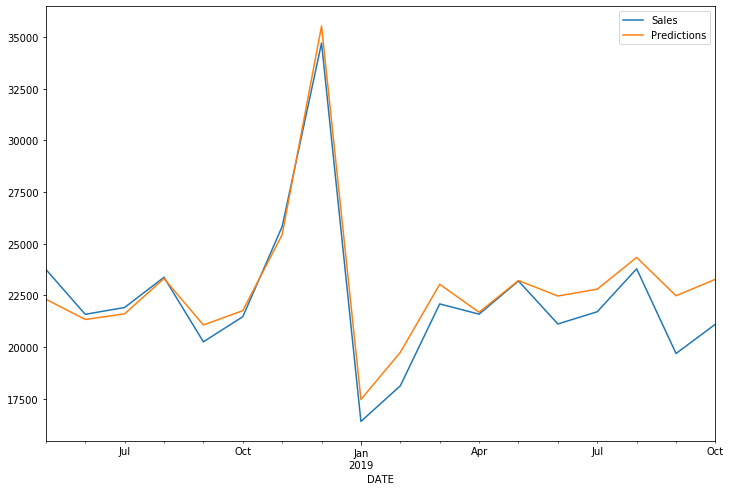

In [61]:
test.plot(figsize=(12,8))

In [62]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [63]:
length = 12
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,
                               length=length,batch_size=1)

In [64]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 7s 22ms/step - loss: 0.0263
Epoch 2/8
322/322 [==============================] - 7s 22ms/step - loss: 0.0178
Epoch 3/8
322/322 [==============================] - 8s 24ms/step - loss: 0.0082
Epoch 4/8
322/322 [==============================] - 11s 33ms/step - loss: 0.0041
Epoch 5/8
322/322 [==============================] - 9s 27ms/step - loss: 0.0034
Epoch 6/8
322/322 [==============================] - 8s 25ms/step - loss: 0.0018
Epoch 7/8
322/322 [==============================] - 8s 25ms/step - loss: 0.0020
Epoch 8/8
322/322 [==============================] - 8s 24ms/step - loss: 0.0013


In [65]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [66]:
forecast = scaler.inverse_transform(forecast)

In [67]:
forecast

array([[26119.06498051],
       [35605.67959976],
       [16596.24237847],
       [18423.77646565],
       [22041.10818768],
       [21677.45063782],
       [23201.38240242],
       [21318.60505819],
       [21906.57003117],
       [23844.30496788],
       [20215.04921317],
       [21616.84378242]])

In [68]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [69]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,
                              freq="MS")

In [70]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [71]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                          columns=['Forecast'])

In [72]:
forecast_df

,Forecast
2019-11-01,26119.064981
2019-12-01,35605.679600
2020-01-01,16596.242378
2020-02-01,18423.776466
2020-03-01,22041.108188
2020-04-01,21677.450638
2020-05-01,23201.382402
2020-06-01,21318.605058
2020-07-01,21906.570031
2020-08-01,23844.304968


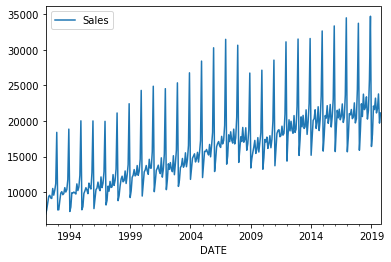

In [76]:
df.plot()

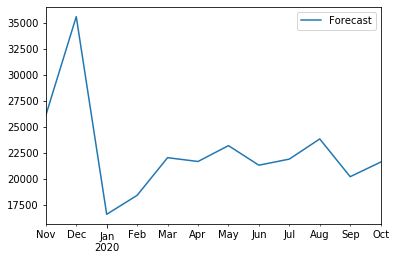

In [74]:
forecast_df.plot()

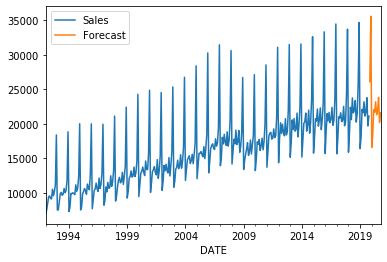

In [78]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01')